In [32]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

import healpy as hp

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

import dill

from emcee.autocorr import integrated_time

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set CW parameters
cw_inj = jnp.array([8.6000000e+00, jnp.log10(4.e-9), 6.12323400e-17, 0.00000000e+00,
                    0.00000000e+00, 3.09016994e-01, jnp.pi / 2., 0.00000000e+00])

# make PTA and likelihood objects
Np = 20
pta = PTA(Np=Np,
          Tspan_yr=15.,
          Nf=10,
          Nf_cw=15,
          window_ext_yr=7.,
          efacs_inj=jnp.ones(Np),
          model_wn=False,
          model_rn=True,
          model_gwb=True,
          model_cw=True,
          gwb_free_spectral=False,
          cw_inj=cw_inj,
          seed=144)
l = get_likelihood_obj(pta)

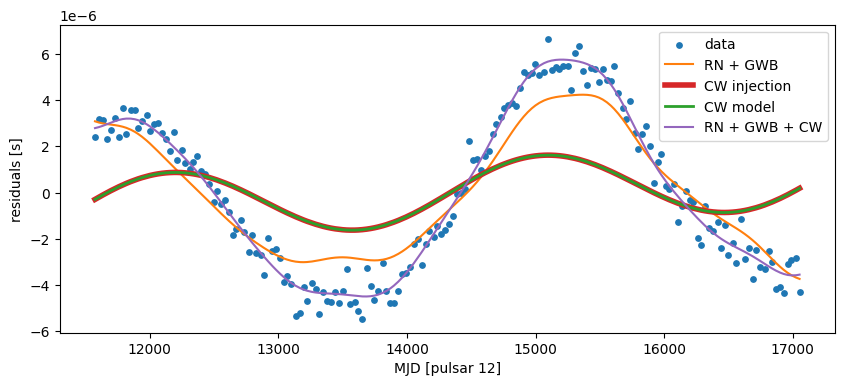

In [3]:
# plot data and injected signals
psr_ndx = 11
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
if pta.model_gwb or pta.model_rn:
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if pta.model_cw:
    cw_signal_inj = pta.Rs[psr_ndx] @ pta.cw_delay_toa_input(pta.x_inj[pta.cw_psr_ndxs], pta.toas)[psr_ndx]
    cw_residuals_model = pta.Rs[psr_ndx] @ pta.Fs_cw[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], cw_signal_inj, color='C3', label='CW injection', lw=4)
    plt.plot(pta.MJDs[psr_ndx], cw_residuals_model, color='C2', label='CW model', lw=2)
if (pta.model_gwb or pta.model_rn) and pta.model_cw:
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_model, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [4]:
# compute SNR of CW signal
if pta.model_cw:
    cw_signal_inj = jnp.array([R @ sig for R, sig in zip(pta.Rs, pta.cw_delay_toa_input(pta.cw_psr_inj, pta.toas))])
    SNR1_sq = jnp.sum(jnp.array([cw_sig.T @ Ntinv @ cw_sig
                                 for cw_sig, Ntinv in zip(cw_signal_inj, pta.Ntinvs)]))
    print(f'SNR1 = {jnp.sqrt(SNR1_sq)}')

    d = pta.residuals - jnp.array([R @ F @ a for R, F, a in zip(pta.Rs, pta.Fs, pta.a_inj.reshape((pta.Np, pta.Na)))])
    ds = jnp.sum(jnp.array([d_val @ Ntinv @ sig for d_val, Ntinv, sig in zip(d, pta.Ntinvs, cw_signal_inj)]))
    ss = jnp.sum(jnp.array([sig @ Ntinv @ sig for sig, Ntinv in zip(cw_signal_inj, pta.Ntinvs)]))
    print(f'SNR2 = {jnp.sqrt(ds**2. / ss)}')

SNR1 = 69.99588824709187
SNR2 = 70.09027737035416


In [5]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    rn_hypers = x[pta.rn_ndxs]
    gwb_hypers = x[pta.gwb_ndxs]
    cw_psr_params = x[pta.cw_psr_ndxs]
    psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    # lnprior_val = l.a_lnprior_gwb(gwb_hypers, a)
    lnprior_val += l.a_lnprior_rn_gwb(rn_hypers, gwb_hypers, a)
    lnprior_val += l.psr_dist_lnprior(psr_dists)
    # lnprior_val += l.a_lnprior_rn(rn_hypers, a)
    # lnprior_val += l.a_lnprior_rn_gwb_free_spectral(rn_hypers, gwb_hypers, a)

    # likelihood
    a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike_cwbasis(pta.efacs_inj, a, a_cw)
    # lnlike_val = l.lnlike(pta.efacs_inj, a)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

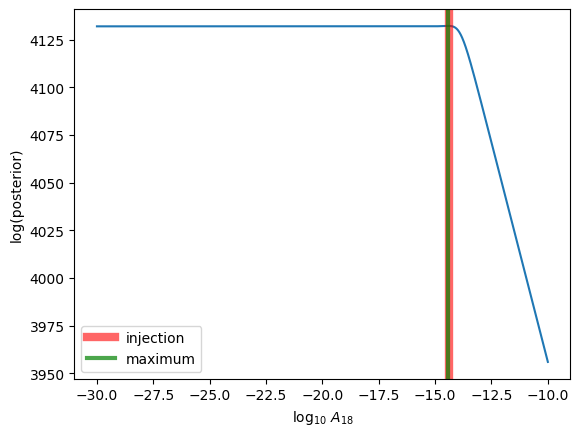

In [6]:
# plot cross-section of posterior
param_ndx = 34
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [7]:
lnpost(pta.x_inj)

Array(4132.22445076, dtype=float64)

In [8]:
# %timeit lnpost(pta.x_inj)

In [9]:
@jit
def transform_a(rn_hypers, gwb_hypers, a_standard):
    rn_phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
    rn_phi = rn_phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
    gwb_phi = pta.get_rho_diag(gwb_hypers)[:, None, None] * pta.alpha[None, :, :]
    # gwb_phi = jnp.repeat(10. ** gwb_hypers, 2)[:, None, None] * pta.alpha[None, :, :]
    phi = gwb_phi + rn_phi
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((pta.Np, pta.Na)).T).T.flatten()
    return a_transformed

@jit
def inv_transform_a(rn_hypers, gwb_hypers, a):
    rn_phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
    rn_phi = rn_phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
    gwb_phi = pta.get_rho_diag(gwb_hypers)[:, None, None] * pta.alpha[None, :, :]
    # gwb_phi = jnp.repeat(10. ** gwb_hypers, 2)[:, None, None] * pta.alpha[None, :, :]
    phi = gwb_phi + rn_phi
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_standard = vmap(lambda L, x: jnp.linalg.inv(L) @ x)(Lc, a.reshape((pta.Np, pta.Na)).T).T.flatten()
    return a_standard

In [10]:
def sampling_model():
    # uniform prior on hyper-parameters
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.rn_mins, pta.rn_maxs))
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

    # uniform prior on CW parameters and pulsar phases
    cw_params = numpyro.sample('cw', dist.Uniform(pta.cw_mins, pta.cw_maxs))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta.psr_phase_mins, pta.psr_phase_maxs))
 
    # normal prior on pulsar distances
    psr_dists_standard = numpyro.sample('psr_dists_standard', dist.Normal().expand((pta.Np,)))
    psr_dists = pta.psr_dists_inj + psr_dists_standard * pta.psr_dists_stdev
    numpyro.deterministic('psr_dists', psr_dists)

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na_PTA]))
    a_transformed = transform_a(rn_hypers, gwb_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)

    # get CW coefficients
    a_cw = pta.get_CW_coefficients(jnp.concatenate((cw_params, psr_phases, psr_dists))).flatten()

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike_cwbasis(pta.efacs_inj, a, a_cw))

In [11]:
# injected parameters in dictionary
x_inj_dict = {'rn_hypers':pta.rn_inj,
              'gwb_hypers':pta.gwb_inj,
              'cw':pta.cw_inj,
              'psr_phases':pta.psr_phases_inj,
              'psr_dists':pta.psr_dists_inj,
              'a_standard':inv_transform_a(pta.rn_inj, pta.gwb_inj, pta.a_inj),
              }

In [37]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 init_strategy=init_to_value(values=x_inj_dict),
                                 # dense_mass=[('rn_hypers',), ('gwb_hypers',), ('cw',)],
                                 dense_mass=[('rn_hypers', 'gwb_hypers', 'cw',), ('a_standard',)],
                                 # dense_mass=True,
                                 max_tree_depth=8,
                                 # target_accept_prob=0.5,
                                 # find_heuristic_step_size=True
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(5e3),
                          num_samples=int(1e4),
                          )

mcmc.run(jr.key(1214))
samples_dict = mcmc.get_samples()

# make samples object for post-processing
samples_arr = np.concatenate((samples_dict['rn_hypers'],
                              samples_dict['gwb_hypers'],
                              samples_dict['cw'],
                              samples_dict['psr_phases'],
                              samples_dict['psr_dists'],
                              samples_dict['a'],
                              ), axis=1)

np.save('samples.npy', samples_arr)

sample:  44%|████▎     | 6528/15000 [16:34<21:31,  6.56it/s, 255 steps of size 1.05e-02. acc. prob=0.72]


KeyboardInterrupt: 

In [23]:
# make samples object for post-processing
samples_arr = jnp.array(np.load('samples.npy'))
samples = Samples(samples_arr=samples_arr,
                  labels=pta.x_labels,
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

In [24]:
# samples.plt_posterior_vals(legend=True)

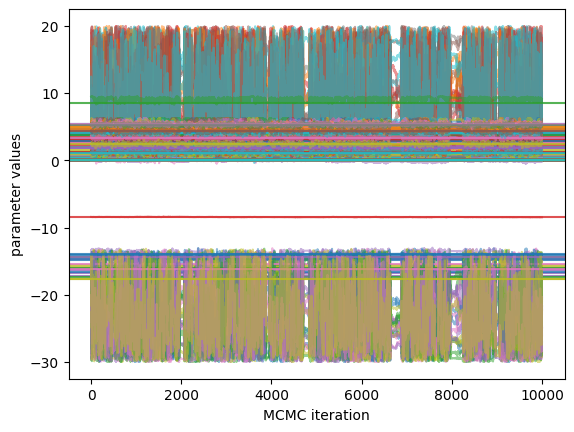

In [25]:
samples.trace_plt()

In [26]:
# samples.plt_auto_corr()

Parameter $\log_{{{10}}}\,A_B$ in chain samples is not constrained
Parameter $\log_{10}\,A_{1}$ in chain samples is not constrained
Parameter $\gamma_{1}$ in chain samples is not constrained
Parameter $\log_{10}(\mathcal{M}\,\,[M_\odot])$ in chain samples is not constrained
Parameter $\log_{10}(D_{L}\,\,[\text{Mpc}])$ in chain samples is not constrained
Parameter $\phi$ in chain samples is not constrained


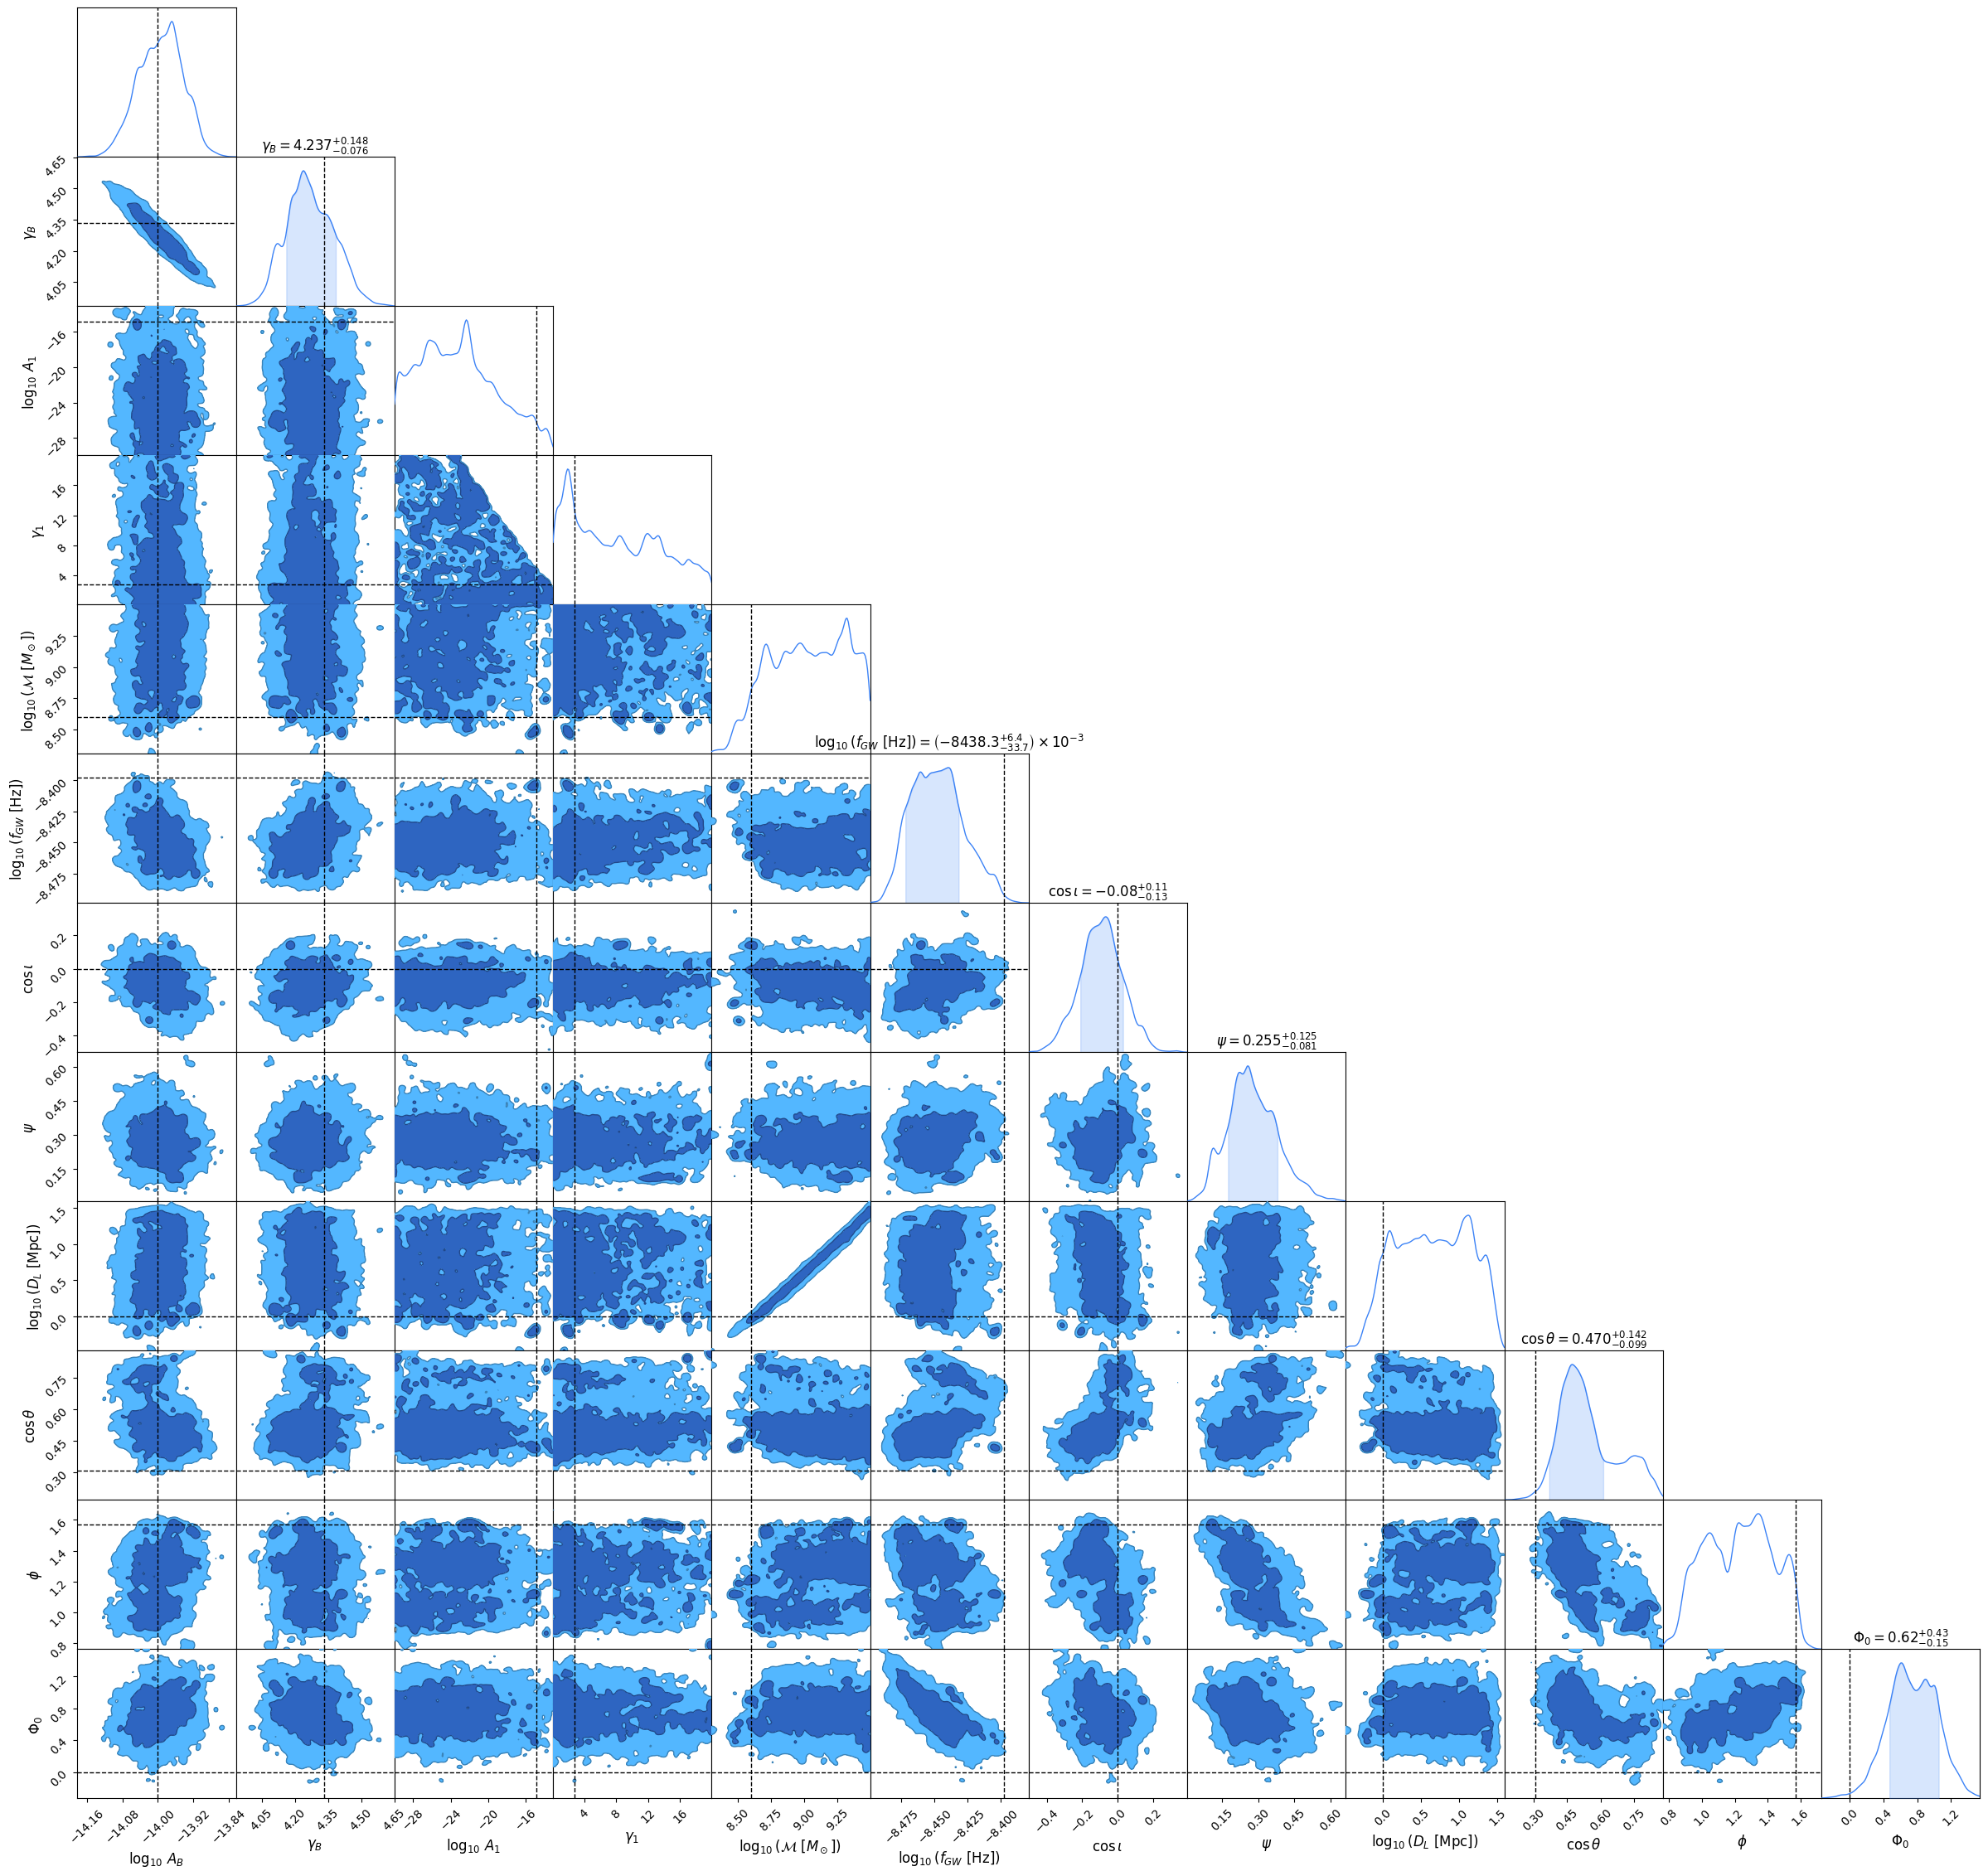

In [27]:
# indices of parameters to use in corner plot
ndxs = np.concatenate((pta.gwb_ndxs,
                       pta.rn_ndxs[:2],
                       pta.cw_ndxs))
samples.corner_plt(param_ndxs=ndxs, burnin=0)

In [35]:
param_ndx = pta.gwb_ndxs[0]
integrated_time(samples.samples[:, param_ndx])

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [743.61619751]

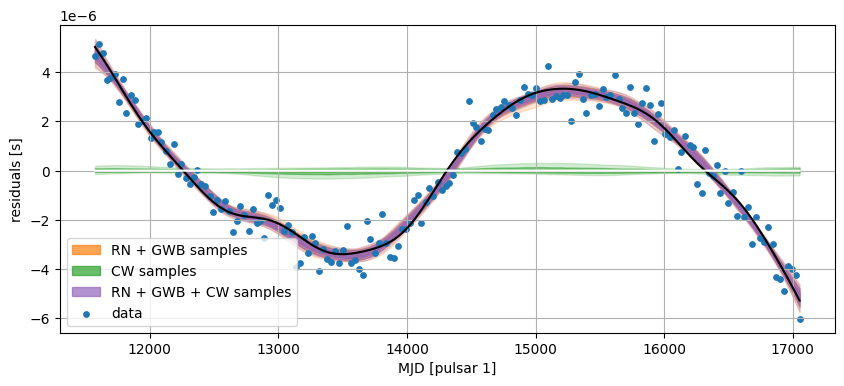

In [28]:
# Bayesogram
# psr_ndx = 0
# for psr_ndx in np.arange(pta.Np):
for psr_ndx in np.arange(1):
    fair_draw_ndxs = np.random.choice(samples.samples.shape[0], (1000,))

    # percentile layers for plotting densities of samples
    percentile_layers = [0.15, 2.5, 16.]
    alphas = [0.2, 0.5, 0.7]

    # plot data, samples, and injected signals
    plt.figure(figsize=(10, 4))
    # plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

    # Bayesogram for RN + GWB
    if pta.model_rn or pta.model_gwb:
        rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples.samples[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                                for ndx in fair_draw_ndxs])
        for percentile, alpha in zip(percentile_layers, alphas):
            if percentile != percentile_layers[-1]:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                                np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                                color='C1', alpha=alpha)
            else:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                                np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                                color='C1', alpha=alpha, label='RN + GWB samples')
        rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
        plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='k')

    # Bayesogram for CW
    if pta.model_cw:
        a_cws = np.array([pta.get_CW_coefficients(samples.samples[ndx, pta.cw_psr_ndxs])[psr_ndx]
                    for ndx in fair_draw_ndxs])
        cw_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs_cw[psr_ndx] @ a_cw for a_cw in a_cws])
        for percentile, alpha in zip(percentile_layers, alphas):
            if percentile != percentile_layers[-1]:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                                np.percentile(cw_signals, 100. - percentile, axis=0),
                                color='C2', alpha=alpha)
            else:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                                np.percentile(cw_signals, 100. - percentile, axis=0),
                                color='C2', alpha=alpha, label='CW samples')
        cw_signal_inj = pta.Rs[psr_ndx] @ pta.cw_delay_toa_input(pta.x_inj[pta.cw_psr_ndxs], pta.toas)[psr_ndx]
        plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ cw_signal_inj, color='white')

    # Bayesogram for RN + GWB + CW
    if pta.model_rn and pta.model_gwb and pta.model_cw:
        signals = cw_signals + rn_gwb_signals
        for percentile, alpha in zip(percentile_layers, alphas):
            if percentile != percentile_layers[-1]:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                                np.percentile(signals, 100. - percentile, axis=0),
                                color='C4', alpha=alpha)
            else:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                                np.percentile(signals, 100. - percentile, axis=0),
                                color='C4', alpha=alpha, label='RN + GWB + CW samples')
        # plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_signal_inj, color='purple', label='RN + GWB + CW injection')


    plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')
    plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
    plt.ylabel('residuals [s]')
    plt.legend()
    plt.grid()
    plt.show()

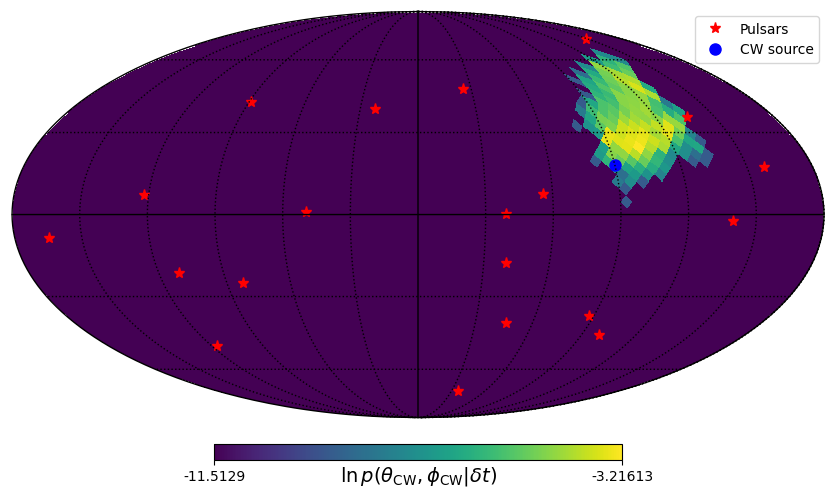

In [29]:
# sky map

# rotate sky map so bounds on azimuthal angle phi is on edges
phi_shift = np.pi

# pulsar positions
theta_psr = np.arccos(pta.psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.mod(np.arctan2(pta.psr_pos[:, 1], pta.psr_pos[:, 0]), 2 * np.pi)

# resolution
nside = 16
npix = hp.nside2npix(nside)

# convert CW sky samples to healpix pixel indices
cos_gwtheta_samples = samples.samples[:, pta.cw_ndxs][:,-3]
gwphi_samples = samples.samples[:, pta.cw_ndxs][:,-2]
pix_indices = hp.ang2pix(nside, np.arccos(cos_gwtheta_samples), gwphi_samples + phi_shift)

# count number of samples in each pixel
density_map = np.bincount(pix_indices, minlength=npix).astype(float)

# normalize to show as a probability density
density_map /= np.sum(density_map)

# plot sky map with posterior density
hp.mollview(np.log(density_map + 1.e-5),
            title='',
            unit=r'$\ln p(\theta_\text{CW}, \phi_\text{CW} | \delta t)$',
            cmap='viridis')

# overlay pulsar positions
hp.projplot(theta_psr, phi_psr + phi_shift, 'r*', markersize=8)
hp.projplot([], [], 'r*', markersize=8, label='Pulsars')

# overlay injected GW source position
cos_gwtheta_inj = pta.x_inj[pta.cw_ndxs][-3]
gwphi_inj = pta.x_inj[pta.cw_ndxs][-2]
hp.projplot(np.arccos(cos_gwtheta_inj), gwphi_inj + phi_shift, 'bo', markersize=8, label='CW source')

hp.graticule()
plt.legend()
plt.show()

In [30]:
# run_fn = 'run7'

# with open(f'runs/{run_fn}/pta.pkl', 'wb') as f:
#     dill.dump(pta, f)

# with open(f'runs/{run_fn}/samples.pkl', 'wb') as f:
#     dill.dump(samples, f)